In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import gc

torch.cuda.empty_cache()
gc.collect()
print("Libraries loaded!")


Libraries loaded!


In [ ]:

LUNG_TRAIN = '/kaggle/input/covidqu/Lung Segmentation Data/Lung Segmentation Data/Train'
LUNG_VAL   = '/kaggle/input/covidqu/Lung Segmentation Data/Lung Segmentation Data/Val'
LUNG_TEST  = '/kaggle/input/covidqu/Lung Segmentation Data/Lung Segmentation Data/Test'

INF_TRAIN  = '/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data/Train'
INF_VAL    = '/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data/Val'
INF_TEST   = '/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data/Test'

IMAGE_SIZE    = 256
BATCH_SIZE    = 16
NUM_EPOCHS    = 10
LEARNING_RATE = 1e-4
NUM_WORKERS   = 2
PIN_MEMORY    = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device : {DEVICE}")
if torch.cuda.is_available():
    print(f"GPU    : {torch.cuda.get_device_name(0)}")
    print(f"VRAM   : {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("WARNING: No GPU detected!")


Device : cuda
GPU    : Tesla P100-PCIE-16GB
VRAM   : 17.1 GB


In [3]:
class COVIDDataset(Dataset):
    def __init__(self, root_dir, mask_type='lung', image_size=256, augment=False):
        assert mask_type in ('lung', 'infection'), "mask_type must be 'lung' or 'infection'"
        self.image_size = image_size
        self.augment    = augment
        self.samples    = []
        mask_folder     = 'lung masks' if mask_type == 'lung' else 'infection masks'

        for label in sorted(os.listdir(root_dir)):
            label_path = os.path.join(root_dir, label)
            if not os.path.isdir(label_path):
                continue
            images_dir = os.path.join(label_path, 'images')
            masks_dir  = os.path.join(label_path, mask_folder)
            # infection masks only exist for COVID-19 → skip others silently
            if not os.path.exists(images_dir) or not os.path.exists(masks_dir):
                continue
            for fname in sorted(os.listdir(images_dir)):
                img_path  = os.path.join(images_dir, fname)
                mask_path = os.path.join(masks_dir,  fname)
                if os.path.exists(mask_path):
                    self.samples.append((img_path, mask_path))

        print(f"  [{mask_type:9s}] {os.path.basename(root_dir):6s} → {len(self.samples):6,} samples")

    def __len__(self):
        return len(self.samples)

    def _augment(self, img, mask):
        if np.random.rand() > 0.5:              # horizontal flip
            img, mask = cv2.flip(img, 1), cv2.flip(mask, 1)
        if np.random.rand() > 0.5:              # rotation ±15°
            a = np.random.uniform(-15, 15)
            h, w = img.shape
            M    = cv2.getRotationMatrix2D((w/2, h/2), a, 1.0)
            img  = cv2.warpAffine(img,  M, (w, h), borderMode=cv2.BORDER_REFLECT)
            mask = cv2.warpAffine(mask, M, (w, h), borderMode=cv2.BORDER_CONSTANT)
        if np.random.rand() > 0.5:              # brightness ±20%
            img = np.clip(img * np.random.uniform(0.8, 1.2), 0, 255).astype(np.uint8)
        return img, mask

    def __getitem__(self, idx):
        img_path, mask_path = self.samples[idx]
        img  = cv2.imread(img_path,  cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if img is None or mask is None:
            z = torch.zeros(1, self.image_size, self.image_size)
            return z, z
        if self.augment:
            img, mask = self._augment(img, mask)
        img  = cv2.resize(img,  (self.image_size, self.image_size), interpolation=cv2.INTER_AREA)
        mask = cv2.resize(mask, (self.image_size, self.image_size), interpolation=cv2.INTER_NEAREST)
        img  = torch.from_numpy(img.astype(np.float32) / 255.0).unsqueeze(0)
        mask = torch.from_numpy((mask > 127).astype(np.float32)).unsqueeze(0)
        return img, mask


def make_loaders(train_dir, val_dir, test_dir, mask_type):
    print(f"\nCreating [{mask_type.upper()}] dataloaders...")
    train_ds = COVIDDataset(train_dir, mask_type, IMAGE_SIZE, augment=True)
    val_ds   = COVIDDataset(val_dir,   mask_type, IMAGE_SIZE, augment=False)
    test_ds  = COVIDDataset(test_dir,  mask_type, IMAGE_SIZE, augment=False)
    kw = dict(num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
    return (
        DataLoader(train_ds, BATCH_SIZE, shuffle=True,  drop_last=True, **kw),
        DataLoader(val_ds,   BATCH_SIZE, shuffle=False, **kw),
        DataLoader(test_ds,  BATCH_SIZE, shuffle=False, **kw),
        train_ds, val_ds, test_ds
    )


# Lung loaders — all 3 classes (~33,920 total images)
lung_train_loader, lung_val_loader, lung_test_loader, \
    lung_train_ds, lung_val_ds, lung_test_ds = make_loaders(
        LUNG_TRAIN, LUNG_VAL, LUNG_TEST, mask_type='lung')

# Infection loaders — COVID-19 only (~2,913 images)
inf_train_loader, inf_val_loader, inf_test_loader, \
    inf_train_ds, inf_val_ds, inf_test_ds = make_loaders(
        INF_TRAIN, INF_VAL, INF_TEST, mask_type='infection')



Creating [LUNG] dataloaders...
  [lung     ] Train  → 21,715 samples
  [lung     ] Val    →  5,417 samples
  [lung     ] Test   →  6,788 samples

Creating [INFECTION] dataloaders...
  [infection] Train  →  3,728 samples
  [infection] Val    →    932 samples
  [infection] Test   →  1,166 samples


In [39]:
# ── Residual Block ────────────────────────────────────────────────────────────
class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.body = nn.Sequential(
            nn.Conv2d(in_ch,  out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
        )
        self.skip = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 1, bias=False),
            nn.BatchNorm2d(out_ch)
        ) if in_ch != out_ch else nn.Identity()
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.body(x) + self.skip(x))


In [40]:

# ── U-Net with Residual Blocks (~8M params at base_ch=64, 3 encoder levels) ──
class UNetResidual(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, base_ch=64):
        super().__init__()
        b = base_ch
        # Encoder (3 levels)
        self.e1, self.p1 = ResidualBlock(in_ch, b),   nn.MaxPool2d(2)
        self.e2, self.p2 = ResidualBlock(b,   b*2),   nn.MaxPool2d(2)
        self.e3, self.p3 = ResidualBlock(b*2, b*4),   nn.MaxPool2d(2)
        # Bottleneck
        self.bn = ResidualBlock(b*4, b*8)
        # Decoder
        self.u3, self.d3 = nn.ConvTranspose2d(b*8,  b*4, 2, 2), ResidualBlock(b*8,  b*4)
        self.u2, self.d2 = nn.ConvTranspose2d(b*4,  b*2, 2, 2), ResidualBlock(b*4,  b*2)
        self.u1, self.d1 = nn.ConvTranspose2d(b*2,  b,   2, 2), ResidualBlock(b*2,  b)
        self.out = nn.Conv2d(b, out_ch, 1)

    def forward(self, x):
        e1 = self.e1(x)
        e2 = self.e2(self.p1(e1))
        e3 = self.e3(self.p2(e2))
        b  = self.bn(self.p3(e3))
        d3 = self.d3(torch.cat([self.u3(b),  e3], 1))
        d2 = self.d2(torch.cat([self.u2(d3), e2], 1))
        d1 = self.d1(torch.cat([self.u1(d2), e1], 1))
        return self.out(d1)

# Check param count
_m = UNetResidual().to(DEVICE)
n  = sum(p.numel() for p in _m.parameters())
print(f"UNetResidual  params : {n:,}  ({n*4/1e6:.1f} MB fp32)")
if torch.cuda.is_available():
    print(f"GPU memory after model load: {torch.cuda.memory_allocated(0)/1e9:.2f} GB")
del _m; torch.cuda.empty_cache()


UNetResidual  params : 8,045,953  (32.2 MB fp32)
GPU memory after model load: 2.17 GB


In [41]:
# ── Loss Functions ────────────────────────────────────────────────────────────
def bce_loss(pred, target):
    return F.binary_cross_entropy_with_logits(pred, target)

def iou_loss(pred, target, smooth=1e-6):
    pred  = torch.sigmoid(pred)
    inter = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) - inter
    return (1 - (inter + smooth) / (union + smooth)).mean()

def combined_loss(pred, target, alpha=0.5):
    return alpha * bce_loss(pred, target) + (1 - alpha) * iou_loss(pred, target)


In [42]:
# ── Metrics ───────────────────────────────────────────────────────────────────
def calc_mae(pred, target):
    return torch.abs(torch.sigmoid(pred) - target).mean().item()

def calc_iou(pred, target, thresh=0.5):
    pred  = (torch.sigmoid(pred) > thresh).float()
    inter = (pred * target).sum()
    union = pred.sum() + target.sum() - inter
    return ((inter + 1e-6) / (union + 1e-6)).item()


In [43]:
# ── Training Loop ─────────────────────────────────────────────────────────────
def train_model(model, train_loader, val_loader, criterion,
                optimizer, num_epochs, device, save_path, log_path=None):
    from torch.optim.lr_scheduler import ReduceLROnPlateau
    from tqdm import tqdm
    import time

    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5,
                                   patience=7, min_lr=1e-7)
    hist     = {'train_loss': [], 'val_loss': [], 'val_mae': [], 'val_iou': []}
    best_iou = 0.0

    log_file = open(log_path, 'w', buffering=1) if log_path else None

    def log(msg):
        print(msg)
        if log_file:
            log_file.write(msg + '\n')

    header = f"epoch,train_loss,val_loss,val_mae,val_iou,lr,saved"
    if log_file:
        log_file.write(header + '\n')

    for epoch in range(num_epochs):
        t0 = time.time()

        # ── Train ──────────────────────────────────────────────────────────────
        model.train()
        t_loss      = 0.0
        running_avg = 0.0
        pbar = tqdm(train_loader, desc=f"Epoch [{epoch+1:3d}/{num_epochs}] train",
                    leave=False, dynamic_ncols=True, unit='batch')
        for step, (imgs, masks) in enumerate(pbar, 1):
            imgs, masks = imgs.to(device, non_blocking=True), masks.to(device, non_blocking=True)
            loss = criterion(model(imgs), masks)
            optimizer.zero_grad(); loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            t_loss      += loss.item()
            running_avg  = t_loss / step
            pbar.set_postfix(batch_loss=f"{loss.item():.4f}",
                             avg_loss=f"{running_avg:.4f}")
        pbar.close()
        t_loss /= len(train_loader)

        # ── Validate ───────────────────────────────────────────────────────────
        model.eval()
        v_loss = v_mae = v_iou = 0.0
        with torch.no_grad():
            vbar = tqdm(val_loader, desc=f"Epoch [{epoch+1:3d}/{num_epochs}]   val ",
                        leave=False, dynamic_ncols=True, unit='batch')
            for step, (imgs, masks) in enumerate(vbar, 1):
                imgs, masks = imgs.to(device, non_blocking=True), masks.to(device, non_blocking=True)
                out     = model(imgs)
                bl = criterion(out, masks).item()
                bm = calc_mae(out, masks)
                bi = calc_iou(out, masks)
                v_loss += bl; v_mae += bm; v_iou += bi
                vbar.set_postfix(val_loss=f"{v_loss/step:.4f}",
                                 MAE=f"{v_mae/step:.4f}",
                                 IoU=f"{v_iou/step:.4f}")
            vbar.close()
        v_loss /= len(val_loader)
        v_mae  /= len(val_loader)
        v_iou  /= len(val_loader)

        hist['train_loss'].append(t_loss)
        hist['val_loss'].append(v_loss)
        hist['val_mae'].append(v_mae)
        hist['val_iou'].append(v_iou)

        scheduler.step(v_iou)
        lr = optimizer.param_groups[0]['lr']

        if v_iou > best_iou:
            best_iou = v_iou
            torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(),
                        'val_iou': v_iou, 'val_loss': v_loss}, save_path)
            saved = " ✓ saved"
        else:
            saved = ""

        log(f"[{epoch+1:3d}/{num_epochs}] {time.time()-t0:.0f}s | "
            f"train={t_loss:.4f}  val={v_loss:.4f}  "
            f"MAE={v_mae:.4f}  IoU={v_iou:.4f}  lr={lr:.1e}{saved}")

        # CSV row (no spaces)
        if log_file:
            log_file.write(f"{epoch+1},{t_loss:.6f},{v_loss:.6f},"
                           f"{v_mae:.6f},{v_iou:.6f},{lr:.2e},{1 if saved else 0}\n")

        if (epoch + 1) % 20 == 0:
            torch.cuda.empty_cache(); gc.collect()

    log(f"  → Best val IoU: {best_iou:.4f}  saved to '{save_path}'")
    if log_file:
        log_file.close()
        print(f"  → Training log saved to '{log_path}'")
    return hist


def load_best(path):
    m    = UNetResidual().to(DEVICE)
    ckpt = torch.load(path, map_location=DEVICE)
    m.load_state_dict(ckpt['model_state_dict'])
    m.eval()
    print(f"  Loaded '{path}'  (epoch {ckpt['epoch']+1}, val IoU={ckpt['val_iou']:.4f})")
    return m


In [44]:
# ═══════════════════════════════════════════════════════════════════════════════
# PHASE 1a — Lung Segmentation | BCE Loss
# Dataset: Lung Segmentation Data (~33,920 images, all 3 classes)
# ═══════════════════════════════════════════════════════════════════════════════
torch.cuda.empty_cache(); gc.collect()
print("PHASE 1a  |  Lung Segmentation  |  BCE Loss")

lung_bce_model = UNetResidual().to(DEVICE)
lung_bce_opt   = torch.optim.Adam(lung_bce_model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

lung_bce_hist = train_model(
    lung_bce_model, lung_train_loader, lung_val_loader,
    bce_loss, lung_bce_opt, NUM_EPOCHS, DEVICE,
    save_path='best_lung_bce.pth',
    log_path='log_lung_bce.txt'
)
print("✓ Phase 1a complete!\n")


PHASE 1a  |  Lung Segmentation  |  BCE Loss


[  1/10] 177s | train=0.0871  val=0.0413  MAE=0.0278  IoU=0.9408  lr=1.0e-04 ✓ saved


[  2/10] 153s | train=0.0383  val=0.0309  MAE=0.0189  IoU=0.9478  lr=1.0e-04 ✓ saved


[  3/10] 152s | train=0.0333  val=0.0277  MAE=0.0172  IoU=0.9517  lr=1.0e-04 ✓ saved


[  4/10] 153s | train=0.0313  val=0.0281  MAE=0.0174  IoU=0.9520  lr=1.0e-04 ✓ saved


[  5/10] 153s | train=0.0300  val=0.0275  MAE=0.0165  IoU=0.9505  lr=1.0e-04


[  6/10] 161s | train=0.0291  val=0.0267  MAE=0.0162  IoU=0.9535  lr=1.0e-04 ✓ saved


[  7/10] 154s | train=0.0286  val=0.0272  MAE=0.0162  IoU=0.9526  lr=1.0e-04


[  8/10] 154s | train=0.0282  val=0.0251  MAE=0.0156  IoU=0.9558  lr=1.0e-04 ✓ saved


[  9/10] 153s | train=0.0276  val=0.0243  MAE=0.0151  IoU=0.9570  lr=1.0e-04 ✓ saved


[ 10/10] 155s | train=0.0274  val=0.0247  MAE=0.0152  IoU=0.9564  lr=1.0e-04
  → Best val IoU: 0.9570  saved to 'best_lung_bce.pth'
  → Training log saved to 'log_lung_bce.txt'
✓ Phase 1a complete!



In [45]:
# ── PHASE 1b — Lung Segmentation | BCE + IoU Loss ─────────────────────────────
del lung_bce_model; torch.cuda.empty_cache(); gc.collect()
print("PHASE 1b  |  Lung Segmentation  |  BCE + IoU Loss")

lung_comb_model = UNetResidual().to(DEVICE)
lung_comb_opt   = torch.optim.Adam(lung_comb_model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

lung_comb_hist = train_model(
    lung_comb_model, lung_train_loader, lung_val_loader,
    lambda p, t: combined_loss(p, t, alpha=0.5),
    lung_comb_opt, NUM_EPOCHS, DEVICE,
    save_path='best_lung_combined.pth',
    log_path='log_lung_combined.txt'
)
print("✓ Phase 1b complete!\n")


PHASE 1b  |  Lung Segmentation  |  BCE + IoU Loss


[  1/10] 157s | train=0.1010  val=0.0552  MAE=0.0167  IoU=0.9436  lr=1.0e-04 ✓ saved


[  2/10] 153s | train=0.0557  val=0.0486  MAE=0.0143  IoU=0.9484  lr=1.0e-04 ✓ saved


[  3/10] 153s | train=0.0512  val=0.0439  MAE=0.0127  IoU=0.9526  lr=1.0e-04 ✓ saved


[  4/10] 153s | train=0.0483  val=0.0435  MAE=0.0126  IoU=0.9531  lr=1.0e-04 ✓ saved


[  5/10] 166s | train=0.0468  val=0.0425  MAE=0.0126  IoU=0.9540  lr=1.0e-04 ✓ saved


[  6/10] 154s | train=0.0455  val=0.0413  MAE=0.0122  IoU=0.9551  lr=1.0e-04 ✓ saved


[  7/10] 157s | train=0.0448  val=0.0451  MAE=0.0132  IoU=0.9515  lr=1.0e-04


[  8/10] 155s | train=0.0440  val=0.0409  MAE=0.0118  IoU=0.9554  lr=1.0e-04 ✓ saved


[  9/10] 153s | train=0.0435  val=0.0403  MAE=0.0118  IoU=0.9562  lr=1.0e-04 ✓ saved


[ 10/10] 153s | train=0.0428  val=0.0398  MAE=0.0117  IoU=0.9567  lr=1.0e-04 ✓ saved
  → Best val IoU: 0.9567  saved to 'best_lung_combined.pth'
  → Training log saved to 'log_lung_combined.txt'
✓ Phase 1b complete!



In [48]:
# ── PHASE 2b — Infection Segmentation | BCE + IoU Loss ────────────────────────
try:
    del inf_bce_model
except NameError:
    pass
torch.cuda.empty_cache(); gc.collect()
print("PHASE 2b  |  Infection Segmentation  |  BCE + IoU Loss")


inf_comb_model = UNetResidual().to(DEVICE)
inf_comb_opt   = torch.optim.Adam(inf_comb_model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

inf_comb_hist = train_model(
    inf_comb_model, inf_train_loader, inf_val_loader,
    lambda p, t: combined_loss(p, t, alpha=0.5),
    inf_comb_opt, NUM_EPOCHS, DEVICE,
    save_path='best_infection_combined.pth',
    log_path='log_infection_combined.txt'
)
del inf_comb_model; torch.cuda.empty_cache(); gc.collect()
print("✓ Phase 2b complete!\n")


PHASE 2b  |  Infection Segmentation  |  BCE + IoU Loss


[  1/10] 28s | train=0.5673  val=0.4947  MAE=0.1097  IoU=0.2725  lr=1.0e-04 ✓ saved


[  2/10] 27s | train=0.4947  val=0.4762  MAE=0.0921  IoU=0.2837  lr=1.0e-04 ✓ saved


[  3/10] 27s | train=0.4648  val=0.4493  MAE=0.0778  IoU=0.3133  lr=1.0e-04 ✓ saved


[  4/10] 27s | train=0.4484  val=0.4292  MAE=0.0557  IoU=0.3459  lr=1.0e-04 ✓ saved


[  5/10] 27s | train=0.4372  val=0.4243  MAE=0.0606  IoU=0.3516  lr=1.0e-04 ✓ saved


[  6/10] 26s | train=0.4281  val=0.4228  MAE=0.0520  IoU=0.3400  lr=1.0e-04


[  7/10] 27s | train=0.4226  val=0.4136  MAE=0.0483  IoU=0.3592  lr=1.0e-04 ✓ saved


[  8/10] 26s | train=0.4193  val=0.4122  MAE=0.0490  IoU=0.3592  lr=1.0e-04


[  9/10] 27s | train=0.4141  val=0.4020  MAE=0.0438  IoU=0.3714  lr=1.0e-04 ✓ saved


[ 10/10] 26s | train=0.4105  val=0.4048  MAE=0.0459  IoU=0.3667  lr=1.0e-04
  → Best val IoU: 0.3714  saved to 'best_infection_combined.pth'
  → Training log saved to 'log_infection_combined.txt'
✓ Phase 2b complete!



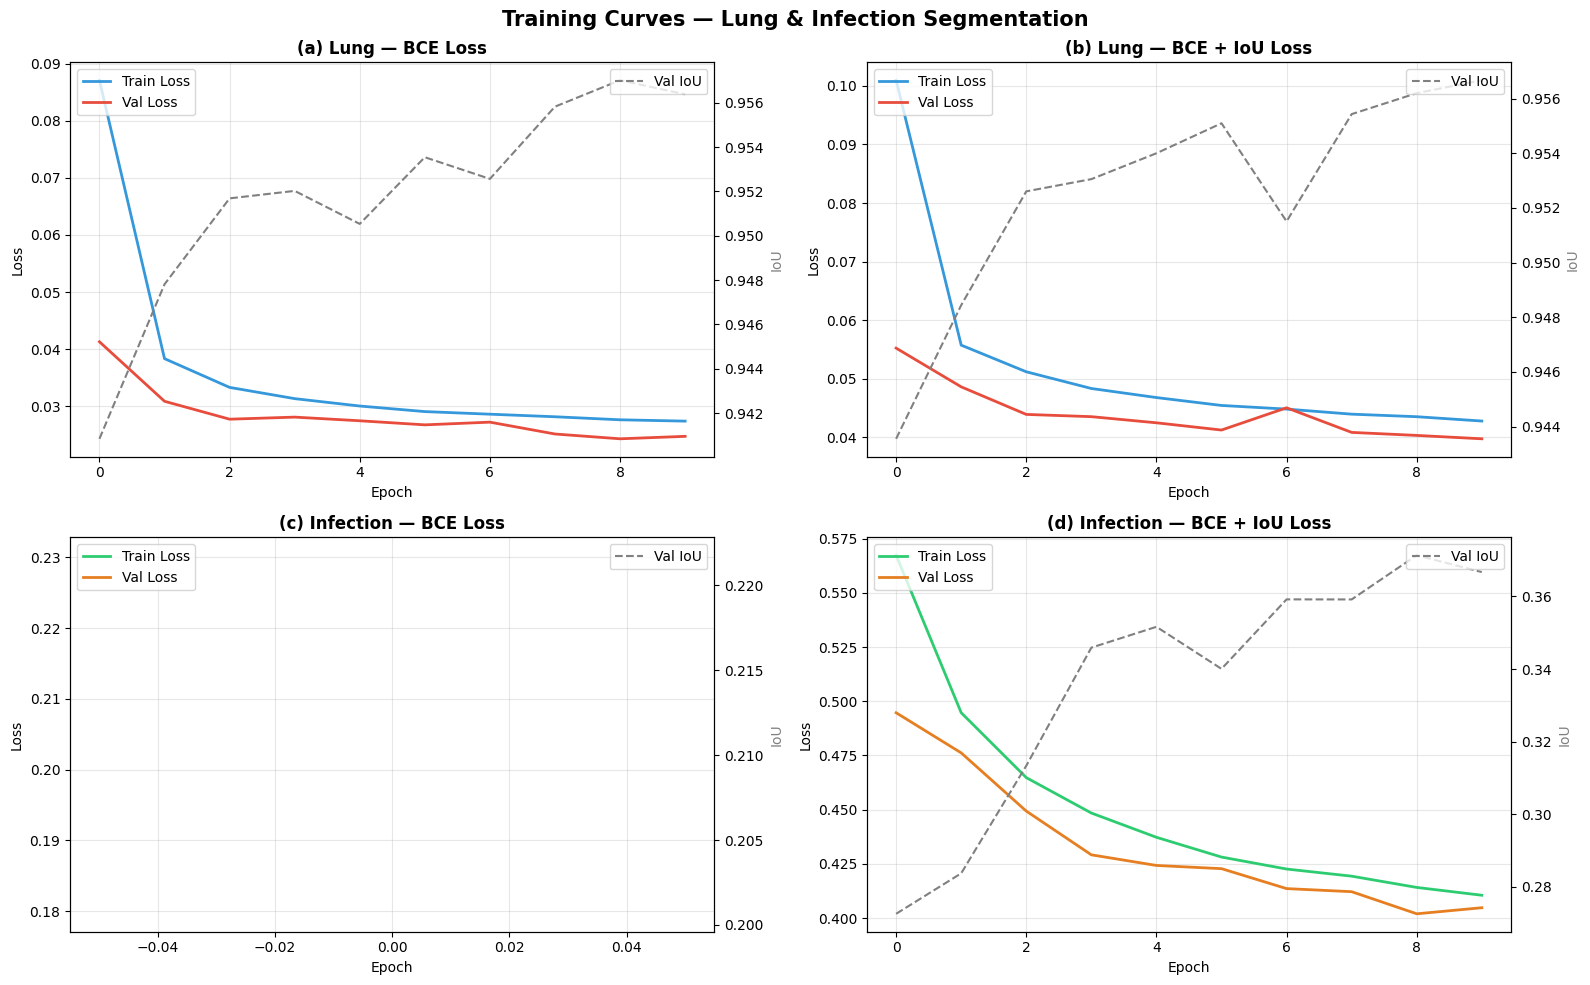

Saved: training_curves_all.png


In [49]:
# ── Training Curves ───────────────────────────────────────────────────────────
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Training Curves — Lung & Infection Segmentation', fontsize=15, fontweight='bold')

configs = [
    (axes[0,0], lung_bce_hist,  '#3498db','#e74c3c', '(a) Lung — BCE Loss'),
    (axes[0,1], lung_comb_hist, '#3498db','#e74c3c', '(b) Lung — BCE + IoU Loss'),
    (axes[1,0], inf_bce_hist,   '#2ecc71','#e67e22', '(c) Infection — BCE Loss'),
    (axes[1,1], inf_comb_hist,  '#2ecc71','#e67e22', '(d) Infection — BCE + IoU Loss'),
]
for ax, hist, c1, c2, title in configs:
    ax.plot(hist['train_loss'], color=c1, label='Train Loss', linewidth=2)
    ax.plot(hist['val_loss'],   color=c2, label='Val Loss',   linewidth=2)
    ax2 = ax.twinx()
    ax2.plot(hist['val_iou'], color='gray', linestyle='--', label='Val IoU', linewidth=1.5)
    ax2.set_ylabel('IoU', color='gray', fontsize=10)
    ax.set_title(title, fontweight='bold'); ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
    ax.legend(loc='upper left'); ax.grid(True, alpha=0.3); ax2.legend(loc='upper right')

plt.tight_layout()
plt.savefig('training_curves_all.png', dpi=200, bbox_inches='tight')
plt.show()
print("Saved: training_curves_all.png")


In [50]:
# ── Test Set Evaluation ───────────────────────────────────────────────────────
def evaluate(ckpt_path, test_loader):
    model = load_best(ckpt_path)
    mae = iou = 0.0
    with torch.no_grad():
        for imgs, masks in test_loader:
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
            out  = model(imgs)
            mae += calc_mae(out, masks)
            iou += calc_iou(out, masks)
    return mae / len(test_loader), iou / len(test_loader), model

print("=" * 65)
print("TEST SET EVALUATION")
print("=" * 65)

mae_lung_bce,  iou_lung_bce,  m_lung_bce  = evaluate('best_lung_bce.pth',          lung_test_loader)
mae_lung_comb, iou_lung_comb, m_lung_comb = evaluate('best_lung_combined.pth',      lung_test_loader)
mae_inf_bce,   iou_inf_bce,   m_inf_bce   = evaluate('best_infection_bce.pth',      inf_test_loader)
mae_inf_comb,  iou_inf_comb,  m_inf_comb  = evaluate('best_infection_combined.pth', inf_test_loader)

print("\nTable: MAE and IoU on Test Dataset")
print("┌──────────────────────────┬──────────┬──────────┐")
print("│  Task / Loss             │   MAE    │   IoU    │")
print("├──────────────────────────┼──────────┼──────────┤")
print(f"│ Lung       / BCE         │  {mae_lung_bce:.4f}  │  {iou_lung_bce:.4f}  │")
print(f"│ Lung       / BCE + IoU   │  {mae_lung_comb:.4f}  │  {iou_lung_comb:.4f}  │")
print(f"│ Infection  / BCE         │  {mae_inf_bce:.4f}  │  {iou_inf_bce:.4f}  │")
print(f"│ Infection  / BCE + IoU   │  {mae_inf_comb:.4f}  │  {iou_inf_comb:.4f}  │")
print("└──────────────────────────┴──────────┴──────────┘")


TEST SET EVALUATION
  Loaded 'best_lung_bce.pth'  (epoch 9, val IoU=0.9570)
  Loaded 'best_lung_combined.pth'  (epoch 10, val IoU=0.9567)
  Loaded 'best_infection_bce.pth'  (epoch 1, val IoU=0.2112)
  Loaded 'best_infection_combined.pth'  (epoch 9, val IoU=0.3714)

Table: MAE and IoU on Test Dataset
┌──────────────────────────┬──────────┬──────────┐
│  Task / Loss             │   MAE    │   IoU    │
├──────────────────────────┼──────────┼──────────┤
│ Lung       / BCE         │  0.0156  │  0.9556  │
│ Lung       / BCE + IoU   │  0.0121  │  0.9552  │
│ Infection  / BCE         │  0.1338  │  0.2166  │
│ Infection  / BCE + IoU   │  0.0445  │  0.3945  │
└──────────────────────────┴──────────┴──────────┘


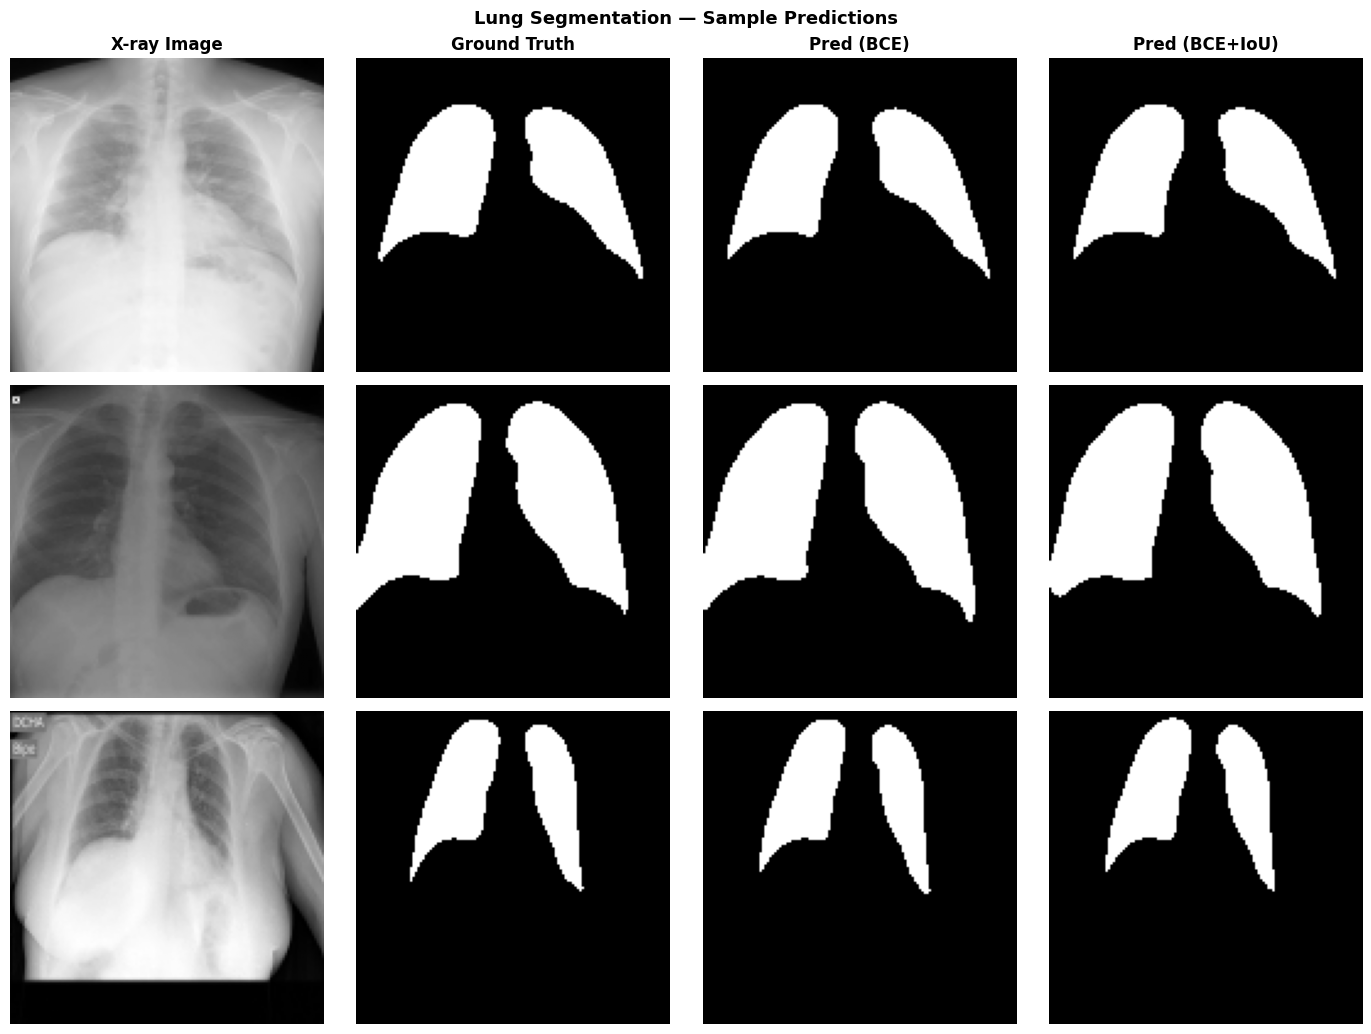

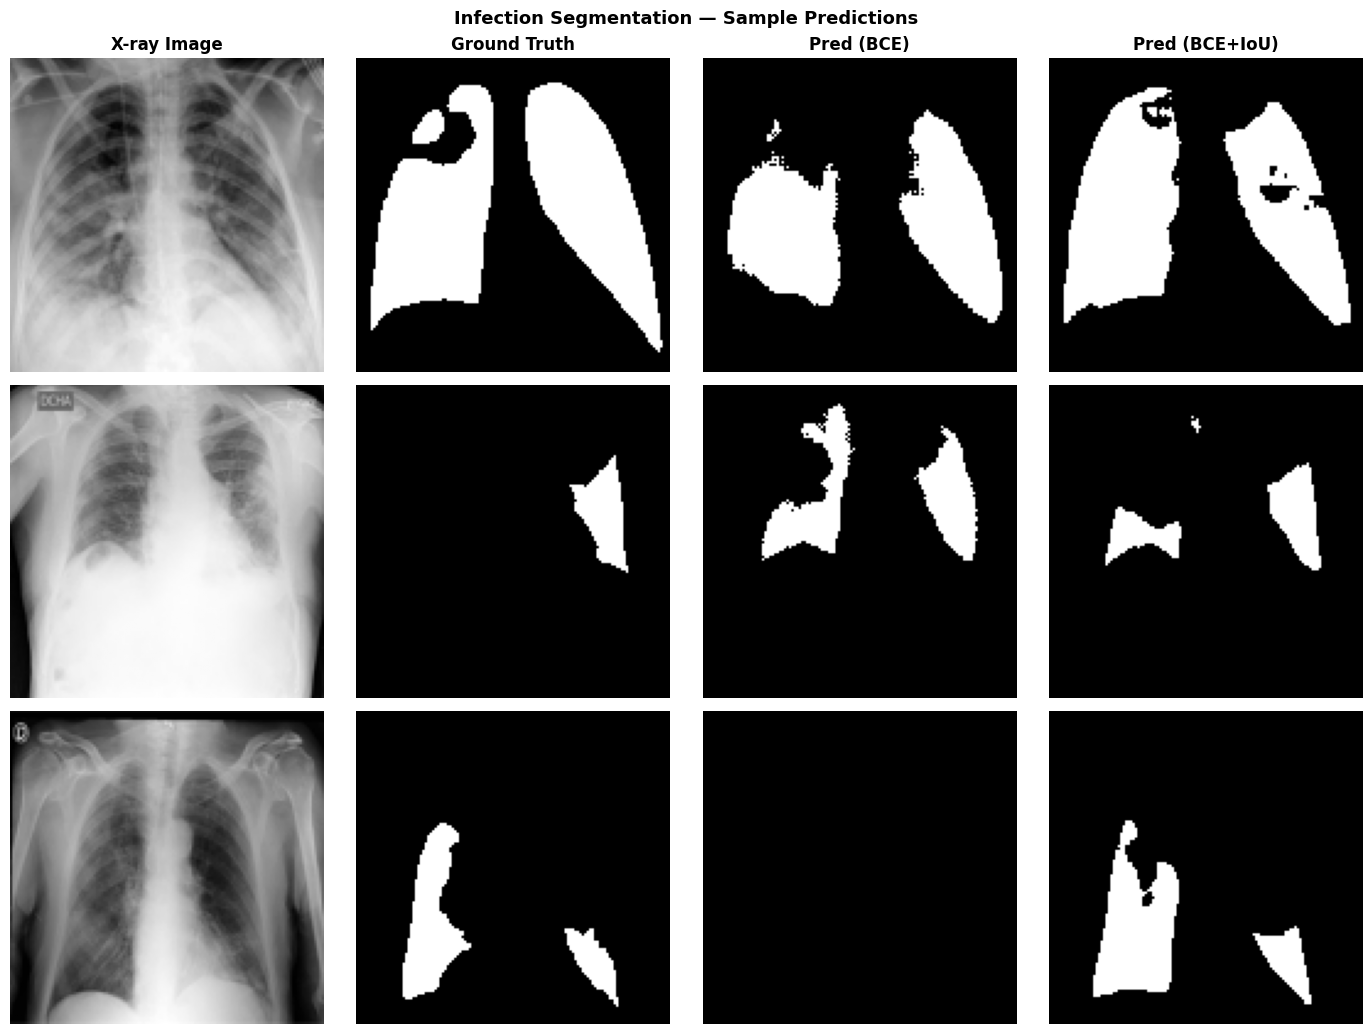

Saved: vis_lung.png  |  vis_infection.png


In [51]:
# ── Visualization ─────────────────────────────────────────────────────────────
def visualize(m_bce, m_comb, dataset, indices, title_prefix):
    for m in (m_bce, m_comb): m.eval()
    fig, axes = plt.subplots(len(indices), 4, figsize=(14, len(indices) * 3.5))
    fig.suptitle(f'{title_prefix} — Sample Predictions', fontsize=13, fontweight='bold')
    if len(indices) == 1:
        axes = axes[np.newaxis, :]
    for j, c in enumerate(['X-ray Image', 'Ground Truth', 'Pred (BCE)', 'Pred (BCE+IoU)']):
        axes[0, j].set_title(c, fontweight='bold')
    with torch.no_grad():
        for i, idx in enumerate(indices):
            img, mask = dataset[idx]
            inp    = img.unsqueeze(0).to(DEVICE)
            p_bce  = (torch.sigmoid(m_bce(inp))  > 0.5).float().squeeze().cpu().numpy()
            p_comb = (torch.sigmoid(m_comb(inp)) > 0.5).float().squeeze().cpu().numpy()
            for j, data in enumerate([img.squeeze().numpy(), mask.squeeze().numpy(), p_bce, p_comb]):
                axes[i, j].imshow(data, cmap='gray'); axes[i, j].axis('off')
    plt.tight_layout()
    return fig

# Lung samples
fig_lung = visualize(m_lung_bce, m_lung_comb, lung_test_ds, [0, 1, 2], 'Lung Segmentation')
plt.savefig('vis_lung.png', dpi=200, bbox_inches='tight'); plt.show()

# Infection samples  
fig_inf = visualize(m_inf_bce, m_inf_comb, inf_test_ds, [0, 1, 2], 'Infection Segmentation')
plt.savefig('vis_infection.png', dpi=200, bbox_inches='tight'); plt.show()

print("Saved: vis_lung.png  |  vis_infection.png")


In [52]:
# ── Summary ───────────────────────────────────────────────────────────────────
n = sum(p.numel() for p in UNetResidual().parameters())
print("=" * 65)
print("               STUDY SUMMARY")
print("=" * 65)
print(f"\nDATASET")
print(f"  Lung Segmentation  : train={len(lung_train_ds):,}  val={len(lung_val_ds):,}  test={len(lung_test_ds):,}")
print(f"  Infection Segment. : train={len(inf_train_ds):,}   val={len(inf_val_ds):,}    test={len(inf_test_ds):,}")
print(f"\nMODEL")
print(f"  Architecture : U-Net with Residual Blocks")
print(f"  Parameters   : {n:,}  ({n*4/1e6:.1f} MB fp32)")
print(f"  Input size   : {IMAGE_SIZE}×{IMAGE_SIZE} px  |  Batch: {BATCH_SIZE}")
print(f"  Optimizer    : Adam  lr={LEARNING_RATE}  weight_decay=1e-5")
print(f"  Scheduler    : ReduceLROnPlateau (mode=max, patience=7)")
print(f"  Grad clip    : 1.0")
print(f"\nTEST RESULTS")
print(f"  {'Task':<24} {'Loss':>10}   {'MAE':>8}   {'IoU':>8}")
print(f"  {'-'*54}")
print(f"  {'Lung      / BCE':<24} {'BCE':>10}   {mae_lung_bce:>8.4f}   {iou_lung_bce:>8.4f}")
print(f"  {'Lung      / BCE+IoU':<24} {'BCE+IoU':>10}   {mae_lung_comb:>8.4f}   {iou_lung_comb:>8.4f}")
print(f"  {'Infection / BCE':<24} {'BCE':>10}   {mae_inf_bce:>8.4f}   {iou_inf_bce:>8.4f}")
print(f"  {'Infection / BCE+IoU':<24} {'BCE+IoU':>10}   {mae_inf_comb:>8.4f}   {iou_inf_comb:>8.4f}")
print(f"\nSAVED FILES")
for f in ['best_lung_bce.pth','best_lung_combined.pth',
          'best_infection_bce.pth','best_infection_combined.pth',
          'training_curves_all.png','vis_lung.png','vis_infection.png']:
    print(f"  {f}")
print("=" * 65)


               STUDY SUMMARY

DATASET
  Lung Segmentation  : train=21,715  val=5,417  test=6,788
  Infection Segment. : train=3,728   val=932    test=1,166

MODEL
  Architecture : U-Net with Residual Blocks
  Parameters   : 8,045,953  (32.2 MB fp32)
  Input size   : 256×256 px  |  Batch: 16
  Optimizer    : Adam  lr=0.0001  weight_decay=1e-5
  Scheduler    : ReduceLROnPlateau (mode=max, patience=7)
  Grad clip    : 1.0

TEST RESULTS
  Task                           Loss        MAE        IoU
  ------------------------------------------------------
  Lung      / BCE                 BCE     0.0156     0.9556
  Lung      / BCE+IoU         BCE+IoU     0.0121     0.9552
  Infection / BCE                 BCE     0.1338     0.2166
  Infection / BCE+IoU         BCE+IoU     0.0445     0.3945

SAVED FILES
  best_lung_bce.pth
  best_lung_combined.pth
  best_infection_bce.pth
  best_infection_combined.pth
  training_curves_all.png
  vis_lung.png
  vis_infection.png
